# 1- Import libraries

In [16]:
import pandas
import konlpy
import gensim
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.1.4
0.6.0
4.3.2


# 2- Loading dataset

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/Users/kenny_jung/aiffel/data/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/Users/kenny_jung/aiffel/data/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 3- Preprocessing

### 3-1 Tokenization, drop duplicates, stopwords

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab('/opt/homebrew/lib/mecab/dic/mecab-ko-dic')
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
X_train[0], y_train[0], X_test[0], y_test[0], word_to_index

([32, 74, 939, 4, 4, 39, 229, 20, 33, 747],
 0,
 [832, 131],
 1,
 {'': 3,
  '.': 4,
  '영화': 5,
  '다': 6,
  '고': 7,
  '하': 8,
  '을': 9,
  '보': 10,
  '..': 11,
  '게': 12,
  ',': 13,
  '!': 14,
  '지': 15,
  '있': 16,
  '없': 17,
  '?': 18,
  '좋': 19,
  '나': 20,
  '었': 21,
  '만': 22,
  '는데': 23,
  '너무': 24,
  '봤': 25,
  '적': 26,
  '안': 27,
  '로': 28,
  '정말': 29,
  '음': 30,
  '것': 31,
  '아': 32,
  '네요': 33,
  '어': 34,
  '재밌': 35,
  '같': 36,
  '점': 37,
  '지만': 38,
  '진짜': 39,
  '했': 40,
  '기': 41,
  '에서': 42,
  '네': 43,
  '않': 44,
  '거': 45,
  '았': 46,
  '수': 47,
  '되': 48,
  '면': 49,
  'ㅋㅋ': 50,
  '말': 51,
  '인': 52,
  '연기': 53,
  '주': 54,
  '내': 55,
  '최고': 56,
  '~': 57,
  '평점': 58,
  '이런': 59,
  '던': 60,
  '어요': 61,
  '할': 62,
  '왜': 63,
  '겠': 64,
  '해': 65,
  '1': 66,
  '스토리': 67,
  '습니다': 68,
  'ㅋㅋㅋ': 69,
  '...': 70,
  '드라마': 71,
  '아니': 72,
  '생각': 73,
  '더': 74,
  '그': 75,
  '싶': 76,
  '사람': 77,
  '듯': 78,
  '때': 79,
  '감동': 80,
  '함': 81,
  '배우': 82,
  '본': 83,
  '까지': 84,
  '뭐': 85

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [30]:
print(index_to_word[9999])

딴따라


### 3-2 Definition functions

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3-3 Max len

In [14]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.971024731364448
문장길이 최대 :  116
문장길이 표준편차 :  12.84408055468762
pad_sequences maxlen :  41
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다. 


### 3-4 Padding

In [22]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=0,
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)
print(len(X_train))
print(len(X_test))
print(len(X_train)+len(X_test))

(146182, 41)
(49157, 41)
146182
49157
195339


# 4- Design models

### 4-1 RNN Recurrent Neural Network Model

In [59]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm_2 (LSTM)               (None, 8)                 3488      
                                                                 
 dense_8 (Dense)             (None, 8)                 72        
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1003569 (3.83 MB)
Trainable params: 1003569 (3.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 4-2 1-D CNN Convolutional Neural Network Model

In [43]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 41   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 41)          410000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          4608      
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 16)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 8)                

### 4-3 Simple DNN Model

In [49]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 41   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 41)          410000    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 41)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 8)                 336       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 410345 (1.57 MB)
Trainable params: 410345 (1.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 5- Training model

In [60]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [62]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 38s 134ms/step - loss: 0.1339 - accuracy: 0.9533 - val_loss: 0.5112 - val_accuracy: 0.8410
Epoch 2/20
266/266 [==============================] - 34s 126ms/step - loss: 0.1266 - accuracy: 0.9555 - val_loss: 0.5377 - val_accuracy: 0.8432
Epoch 3/20
266/266 [==============================] - 32s 121ms/step - loss: 0.1220 - accuracy: 0.9572 - val_loss: 0.5746 - val_accuracy: 0.8388
Epoch 4/20
266/266 [==============================] - 32s 119ms/step - loss: 0.1209 - accuracy: 0.9579 - val_loss: 0.5580 - val_accuracy: 0.8378
Epoch 5/20
266/266 [==============================] - 32s 122ms/step - loss: 0.1193 - accuracy: 0.9575 - val_loss: 0.5472 - val_accuracy: 0.8422
Epoch 6/20
266/266 [==============================] - 32s 119ms/step - loss: 0.1175 - accuracy: 0.9585 - val_loss: 0.5834 - val_accuracy: 0.8352
Epoch 7/20
266/266 [==============================] - 32s 120ms/step - loss: 0.1176 - accuracy: 0.9581 - val_loss: 0.5933 - val_ac

# 6- Evaluation model

### 6-1 RNN model evaluation

In [46]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 15s - loss: 0.9171 - accuracy: 0.8013 - 15s/epoch - 10ms/step
[0.91712886095047, 0.8012694120407104]


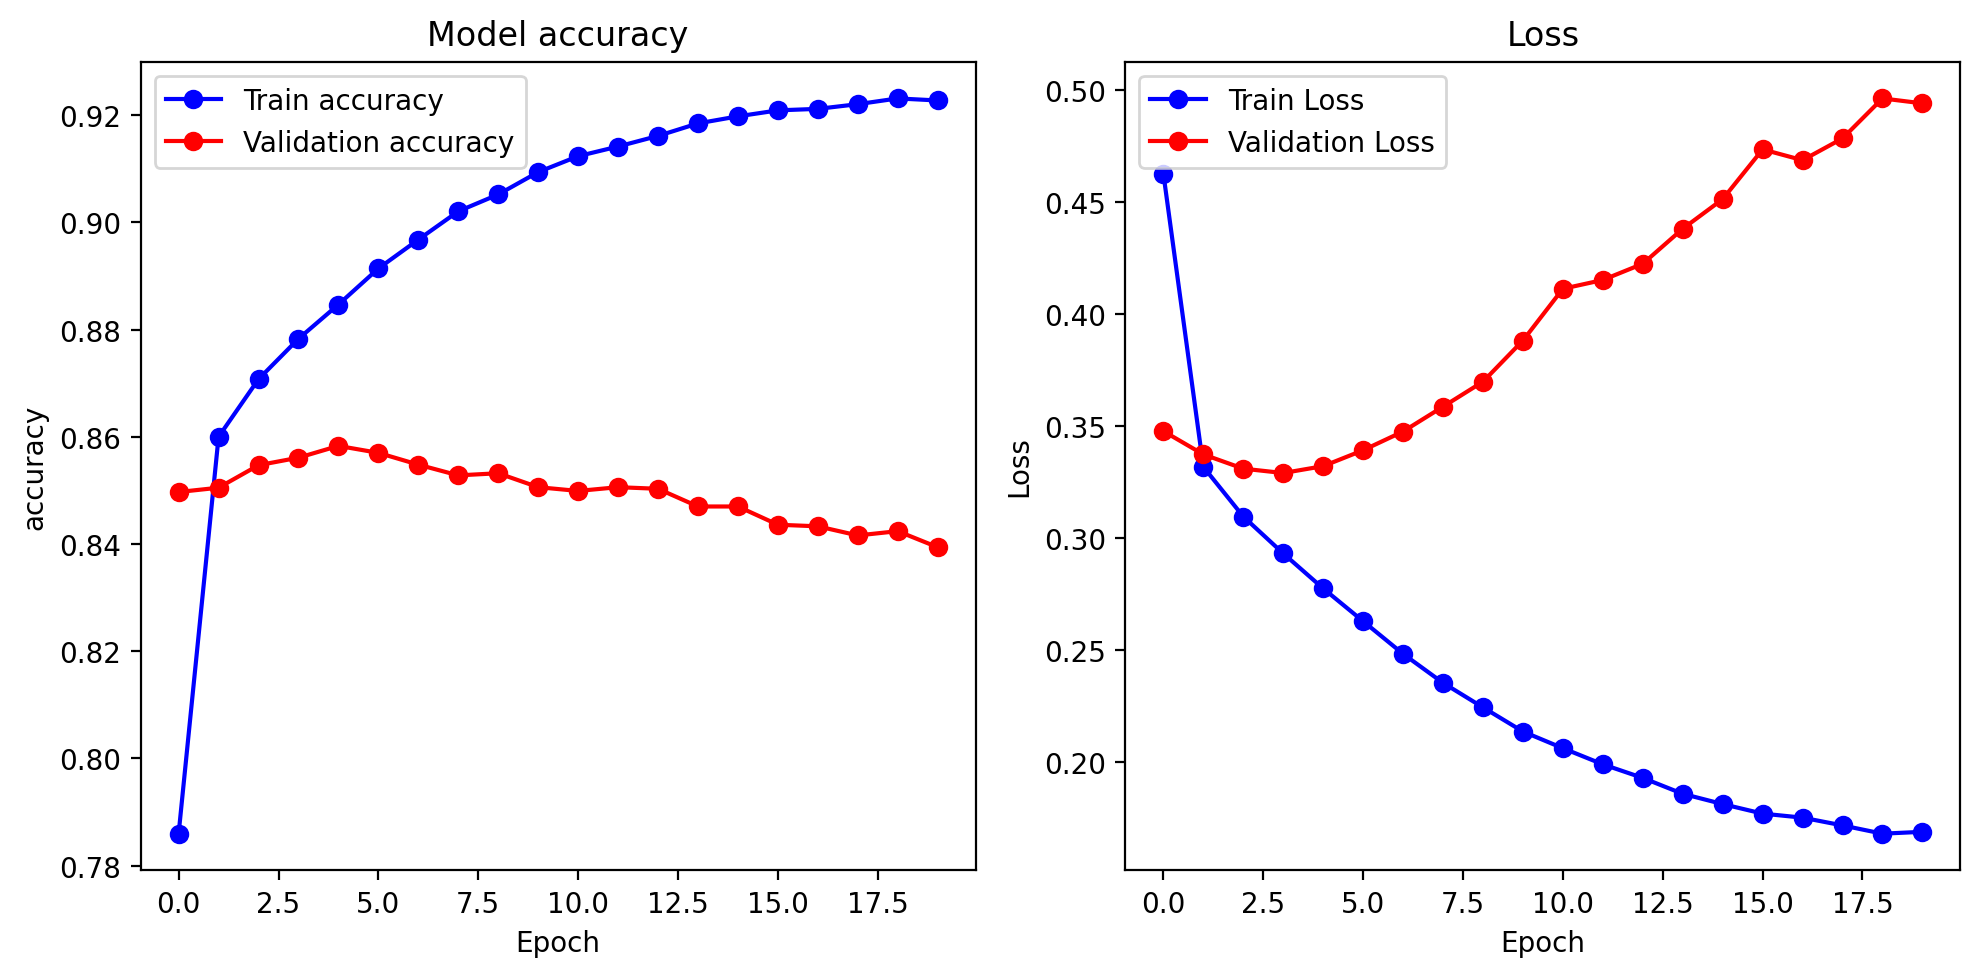

In [41]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 6-2 1-D CNN Model Evaluation

In [47]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 14s - loss: 0.9171 - accuracy: 0.8013 - 14s/epoch - 9ms/step
[0.91712886095047, 0.8012694120407104]


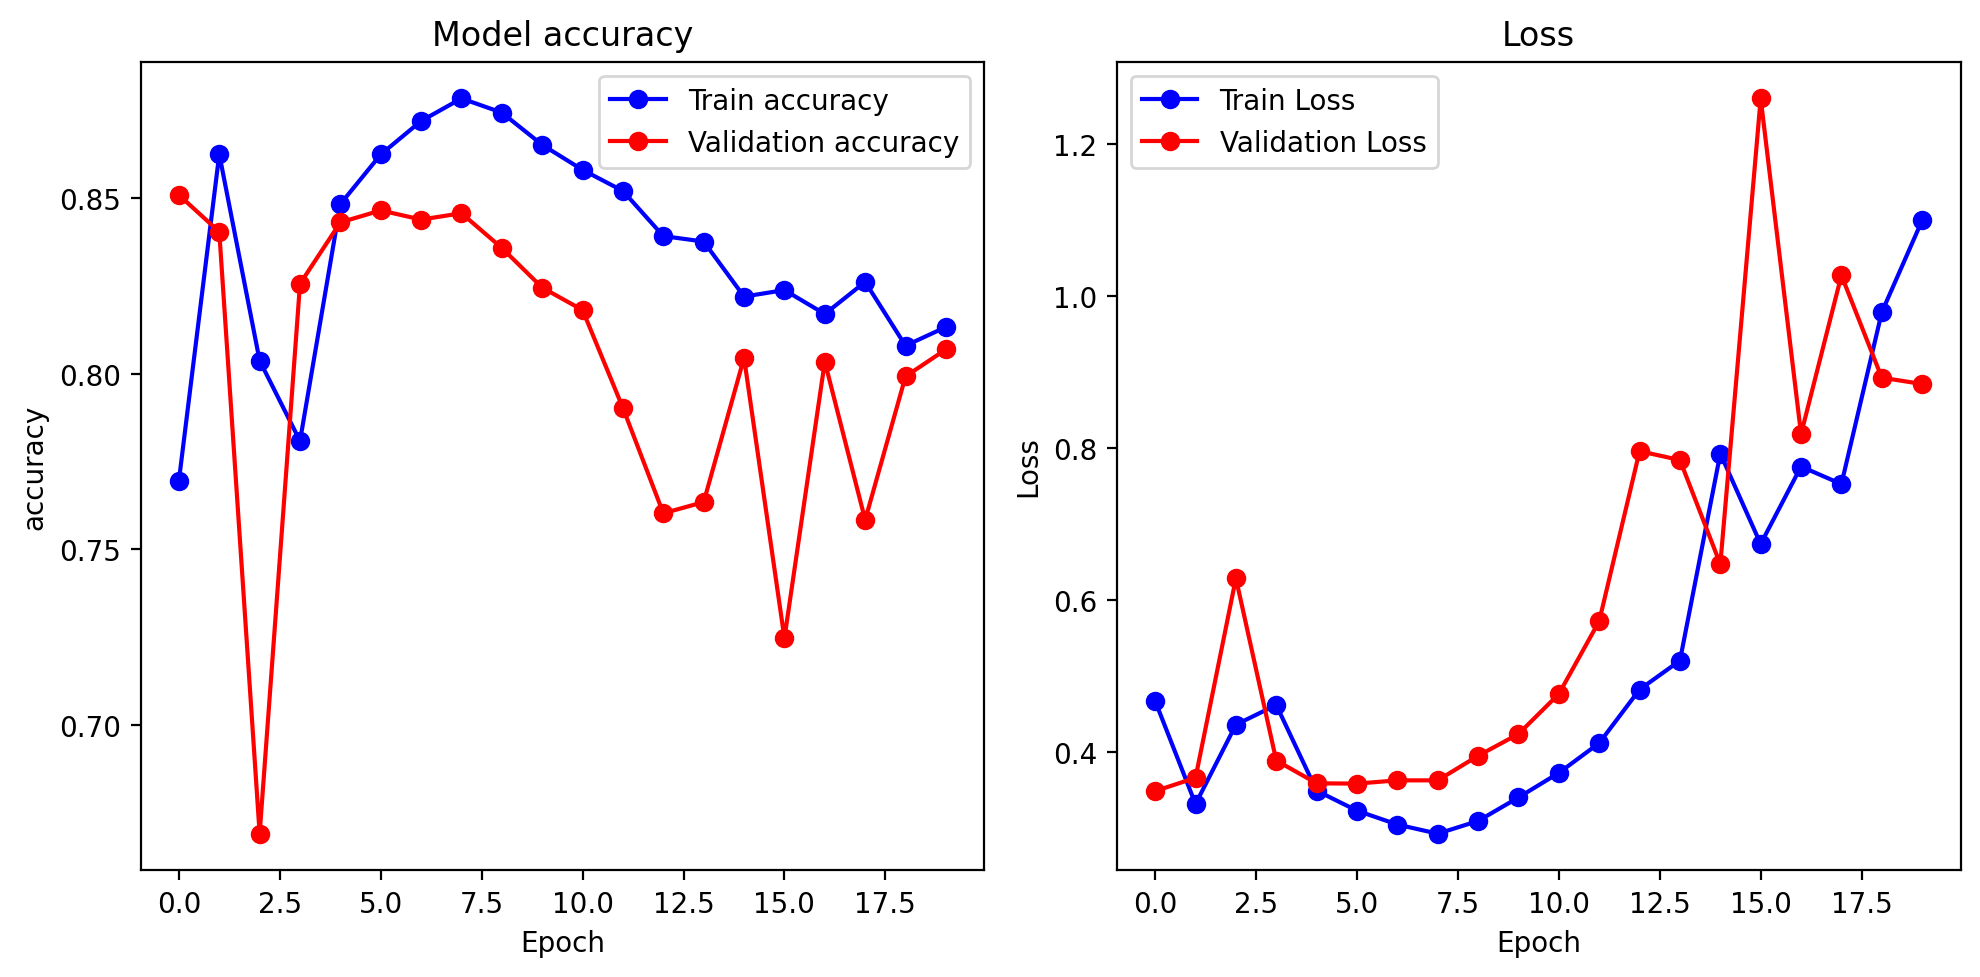

In [48]:
plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 6-3 Basic Evaluation

In [63]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 23s - loss: 0.5404 - accuracy: 0.8249 - 23s/epoch - 15ms/step
[0.5403752326965332, 0.8248672485351562]


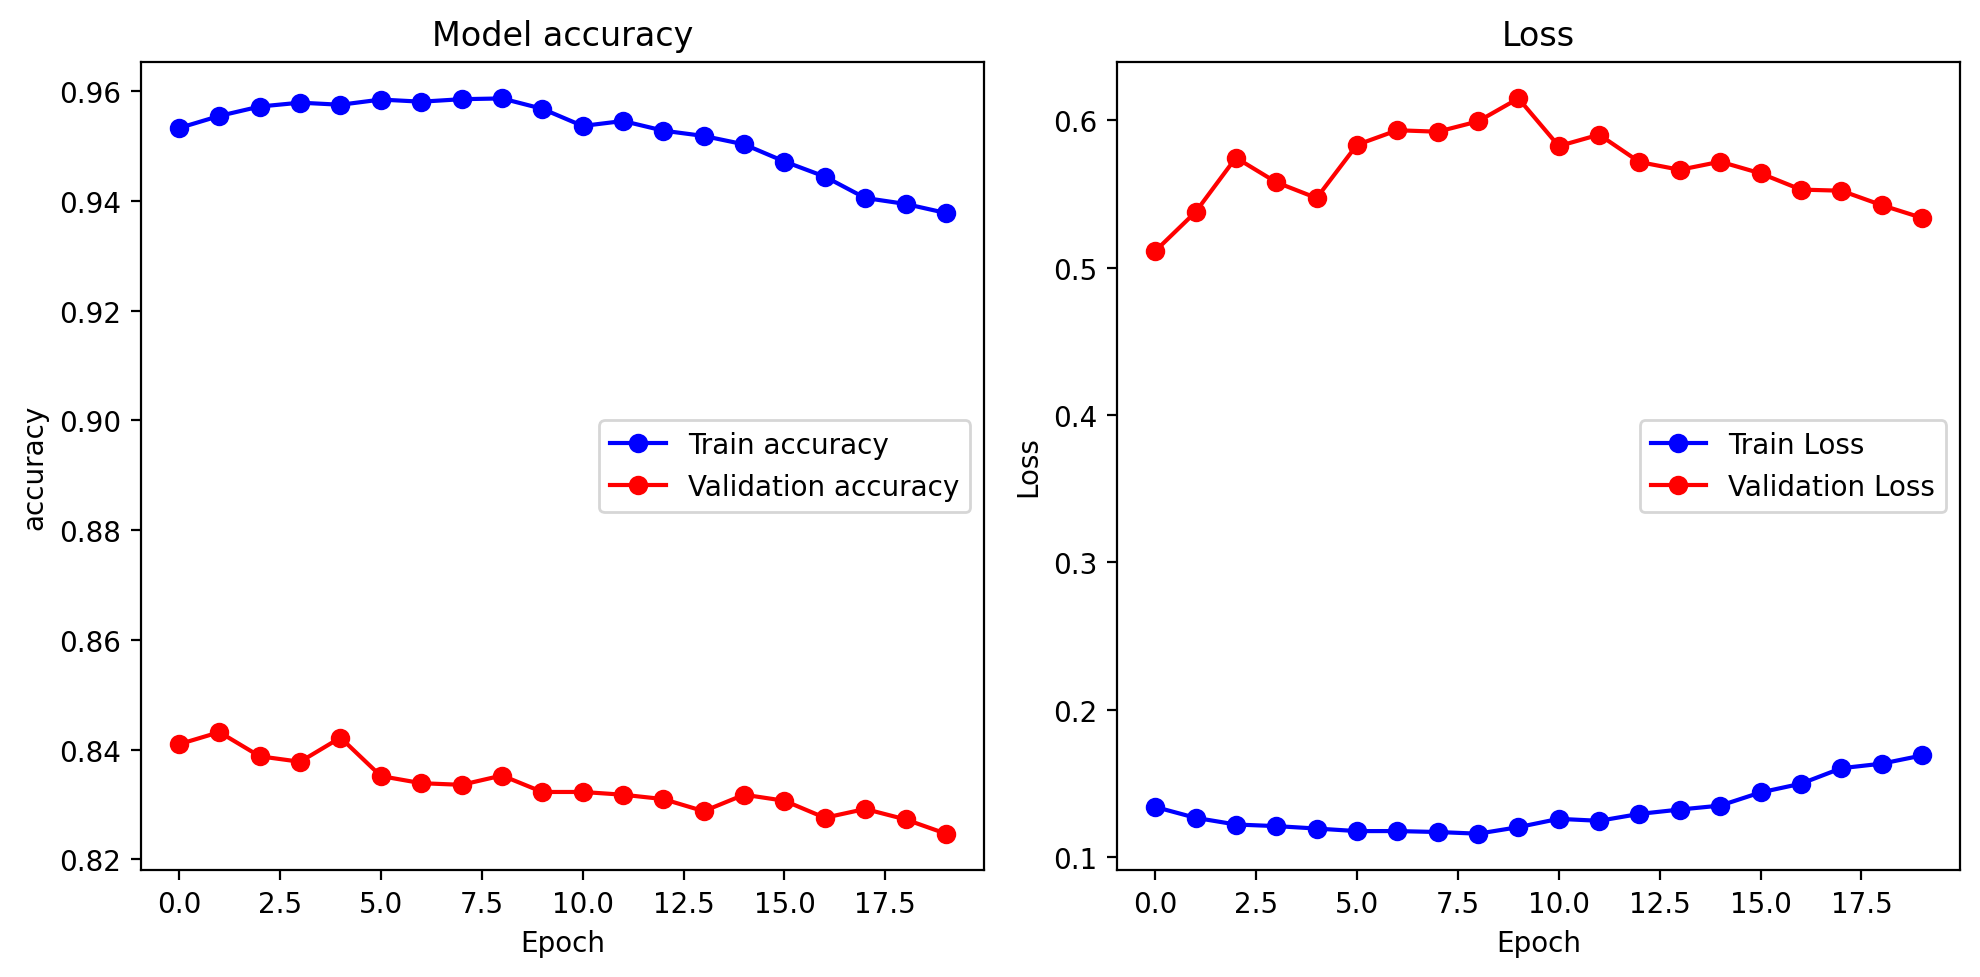

In [64]:
plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 7- word2vec

In [54]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [55]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/Users/kenny_jung/aiffel/data/sentiment_classification/word2vec_naver.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [58]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.21863163,  0.00409354, -0.17210658, -0.07866932,  0.17810842,
       -0.1330122 , -0.11497395,  0.04136174,  0.11735415,  0.02862285,
        0.11391281,  0.08973255, -0.23340742, -0.12905148, -0.24377793,
        0.00180138, -0.19141386,  0.13226724, -0.06914473, -0.21312068,
        0.20240076, -0.03647203, -0.09577069, -0.03304945,  0.18048398,
       -0.08769722, -0.07888807,  0.06492537,  0.06250206, -0.04380122,
        0.13164626, -0.12335931, -0.1555335 , -0.06762449, -0.19799344,
        0.13166851, -0.07827264,  0.12950103, -0.14922205, -0.010029  ,
        0.00834959], dtype=float32)

# 8- word2vec_ko.model

In [82]:
from gensim.models import KeyedVectors
word2vec_path = '/Users/kenny_jung/aiffel/data/sentiment_classification/word2vec_ko.model'
word_vectors = KeyedVectors.load(word2vec_path)
vector = word_vectors.wv["끝"]
print(vector)

[ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134  -2.6863668   0.7999443
 -0.6957915  -0.5018775   3.5025773   0.21326113 -0.6588098  -1.1900496
  0.61399573  2.1247969   0.1549463   3.0840218   3.1680267  -3.9143991
  3.6073153   0.5315545  -0.3511633  -1.107248    1.7767181  -0.95981866
  2.6072454  -0.00697957 -3.27628     1.558644    0.81922376  1.9231955
  3.7026553  -0.53824735 -0.4920138   2.4657123  -2.620749   -0.08950733
  0.61453176  1.8866426   0.257866   -2.7827141   2.9129577  -0.6313133
  2.0387425  -4.222685   -2.7560544   1.7903243  -1.3080189  -2.5531402
 -0.43849912 -3.1073573  -0.29090825  5.1817617   1.9604833  -5.1421604
 -0.71431434  4.5624633  -0.55525815 -3.3019137   1.6761336  -1.9606539
 -0.2726863   0.2465995   1.2685091   1.6055685   1.8344896   1.2752469
  0.99503314 -2.3348706  -0.9290329  -1.5920266   5.693834    1.1132814
 -0.9603875  -1.970055   -1.0120267  -2.7289615  -2.7759619   

In [84]:
word_vectors.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066587805747986),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [86]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [87]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 16)            11216     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 16)             0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 16)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 8)                

In [88]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 33s 118ms/step - loss: 0.6694 - accuracy: 0.5694 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 2/20
266/266 [==============================] - 11s 40ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 3/20
266/266 [==============================] - 9s 35ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4973
Epoch 4/20
266/266 [==============================] - 9s 32ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 5/20
266/266 [==============================] - 9s 33ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 6/20
266/266 [==============================] - 9s 34ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 7/20
266/266 [==============================] - 10s 36ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.

In [89]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 15s - loss: 0.6932 - accuracy: 0.4973 - 15s/epoch - 10ms/step
[0.6931770443916321, 0.4973045587539673]


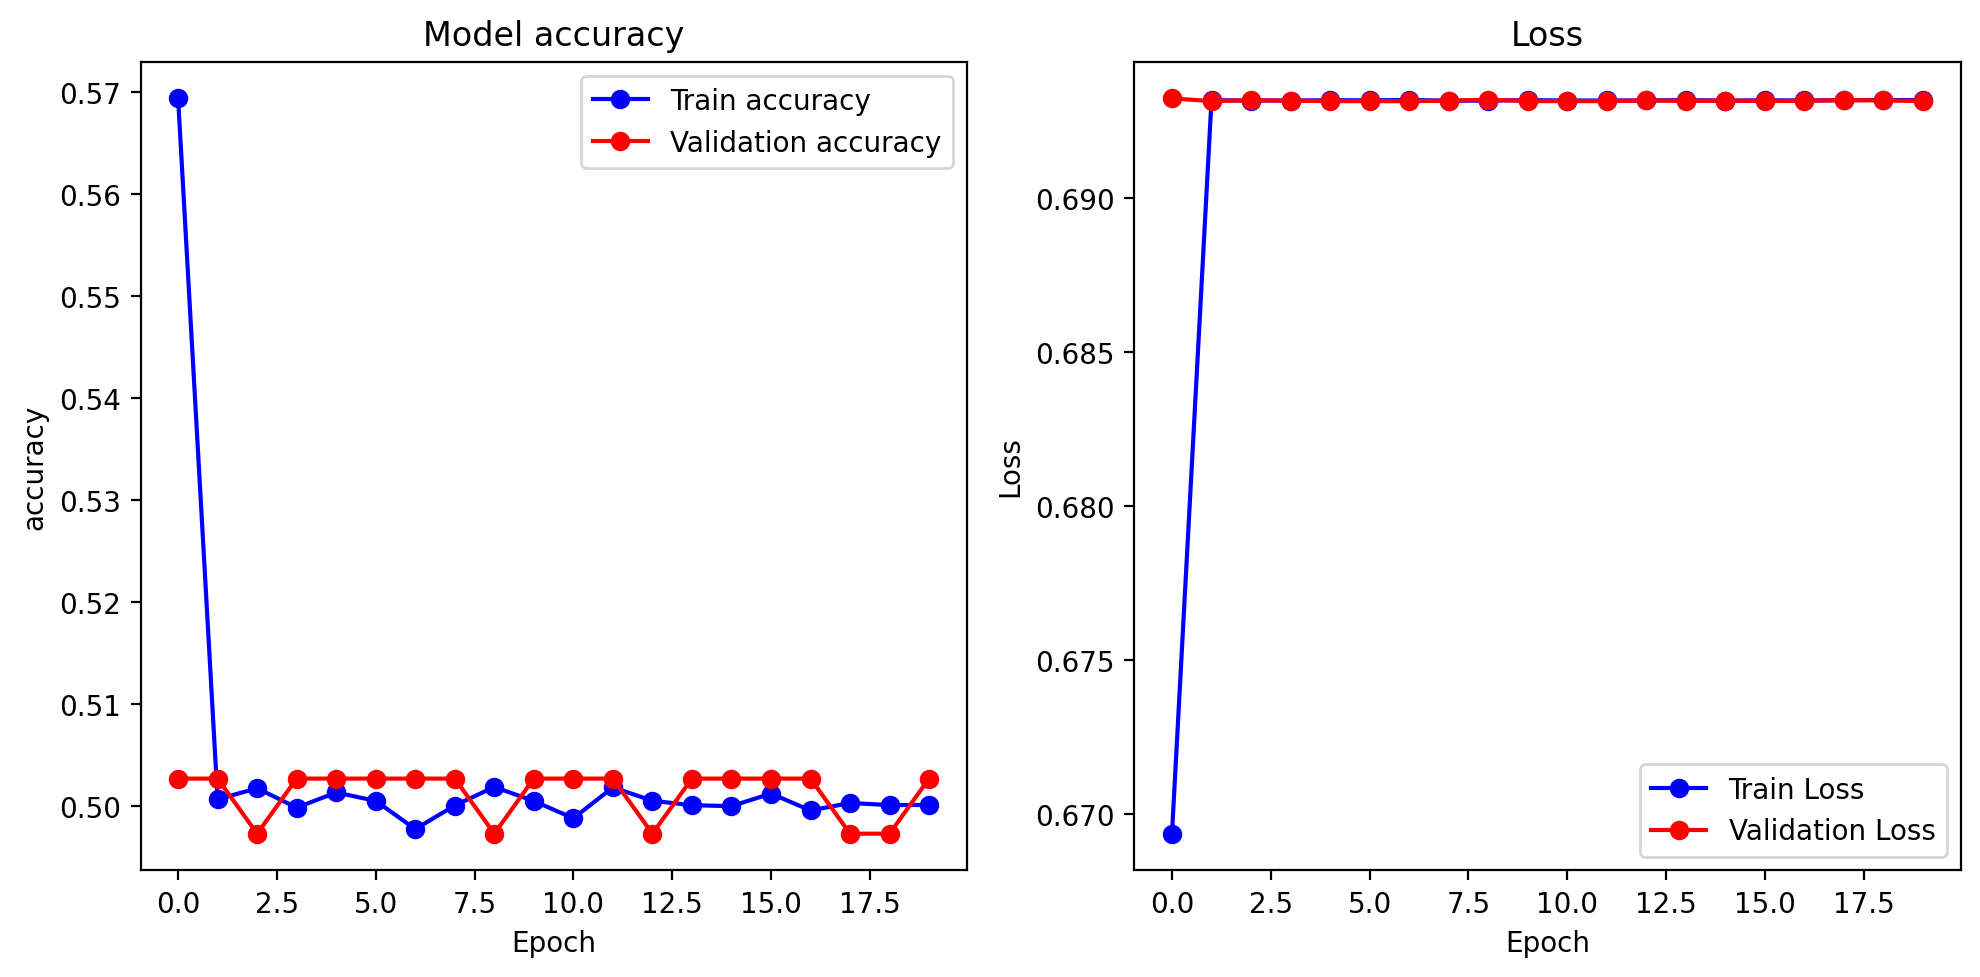

In [90]:
plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()